In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import warnings

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

train_df = pd.read_csv(f'/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks_df = pd.read_csv(f'/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
comb_df = pd.merge(train_df, greeks_df, on='Id')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def my_preprocess(df,sampcols):
    df = df.fillna(0.0001)
    for c in sampcols:
        d = {}
        for i in df.index:
            if df[c][i] not in d:
                d[df[c][i]]=1+len(d)
        df[c] = df[c].map(d)
        print(d)

In [3]:
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [4]:

train_df["EJ"] = train_df["EJ"].map({"B":0.9999,"A":0.0001})

In [5]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

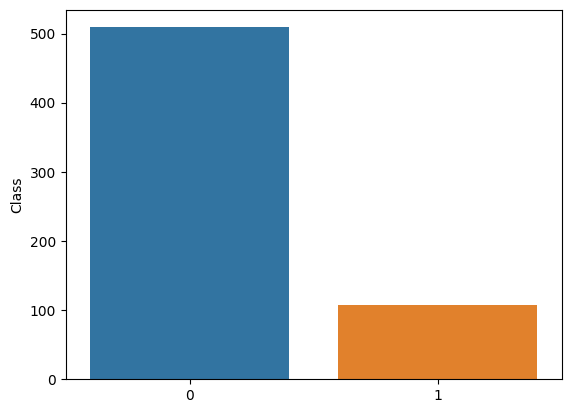

In [8]:
def plot_classes(df):
    x = df['Class'].value_counts().astype(np.int32)
    sns.barplot(x=x.keys(), y=x)
plot_classes(train_df)

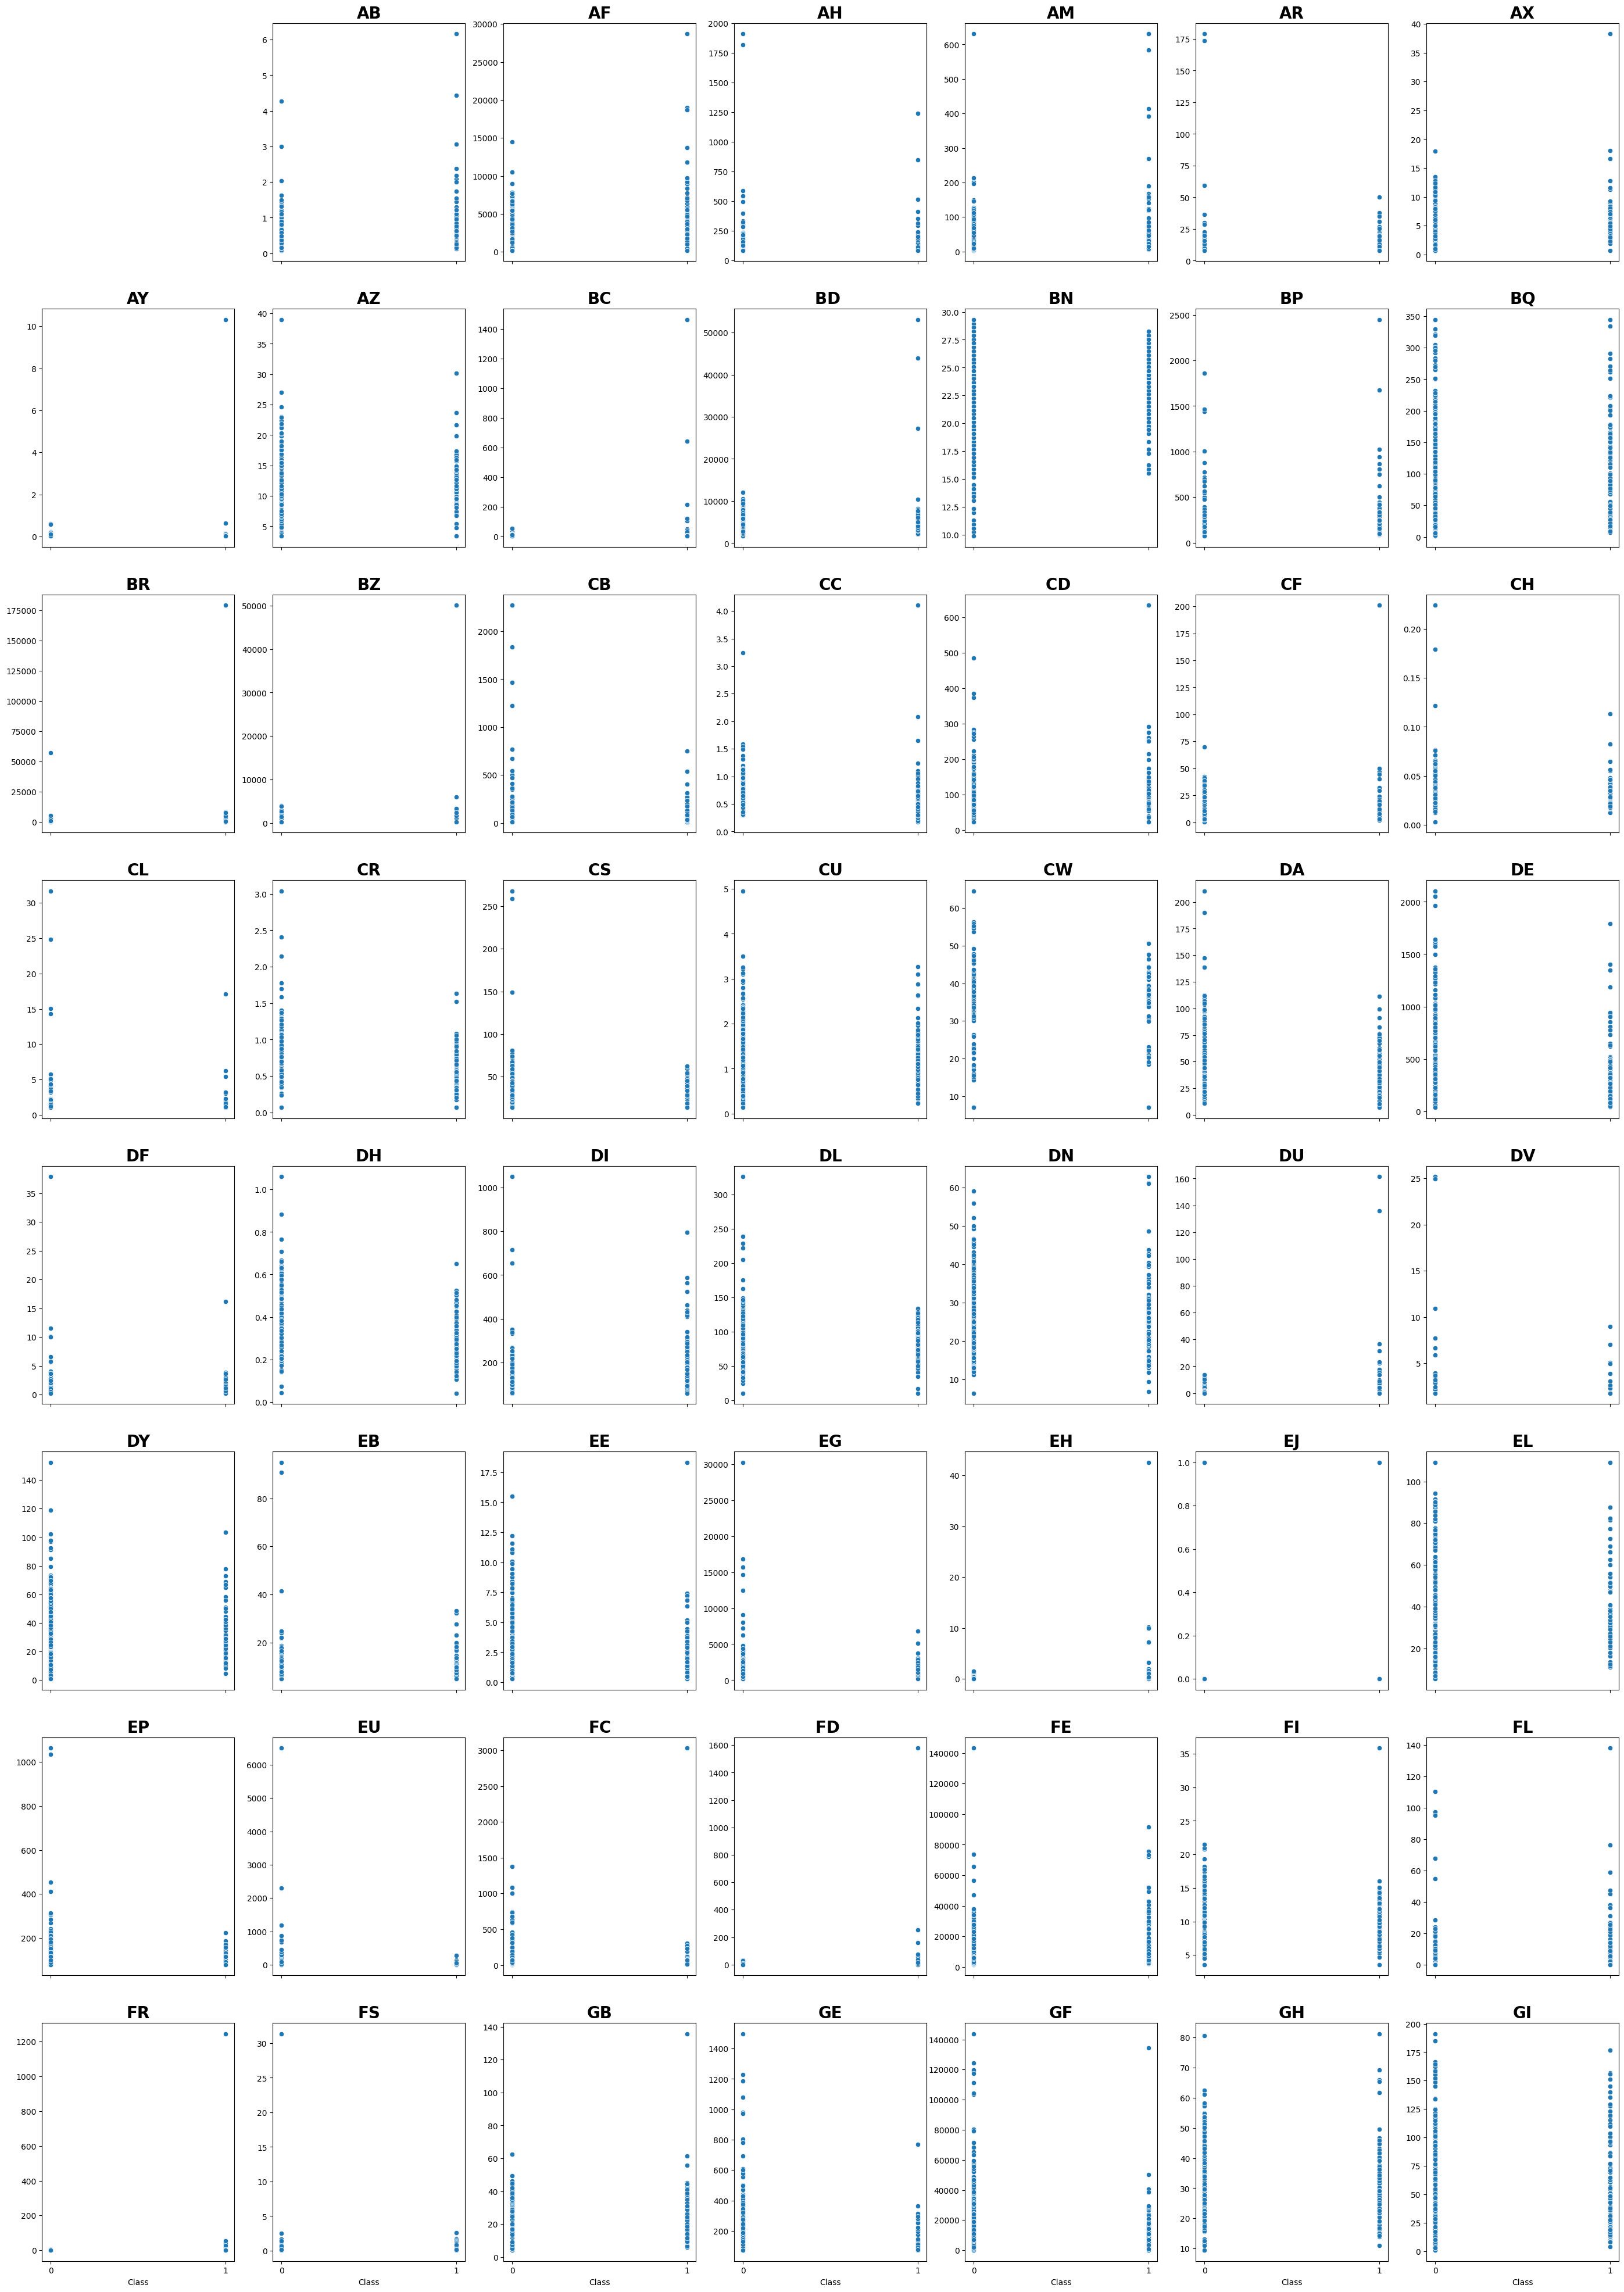

In [9]:
def plot_columns(df):
    COLS = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
            'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE',
            'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
    N_ROWS = 8
    N_COLS = int(len(COLS)/N_ROWS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, sharex=True, figsize=(35,50))
    x = df.loc[:, 'Class']
    for i in range(N_ROWS):
        for j in range(N_COLS):
            idx = (i * (N_COLS-1))+(j+i)
            if idx > 0:
                y=df.iloc[:, idx]
                plot = sns.scatterplot(x=x,y=y.values , ax=axes[i, j])
                plot.set_title(y.name, fontdict={'size': 20, 'weight': 'bold'})
                plot.set_xticks(range(0,2))
    
    fig.delaxes(axes[0][0])        
    fig.show()
                   
plot_columns(train_df)      

<Figure size 3500x5000 with 0 Axes>

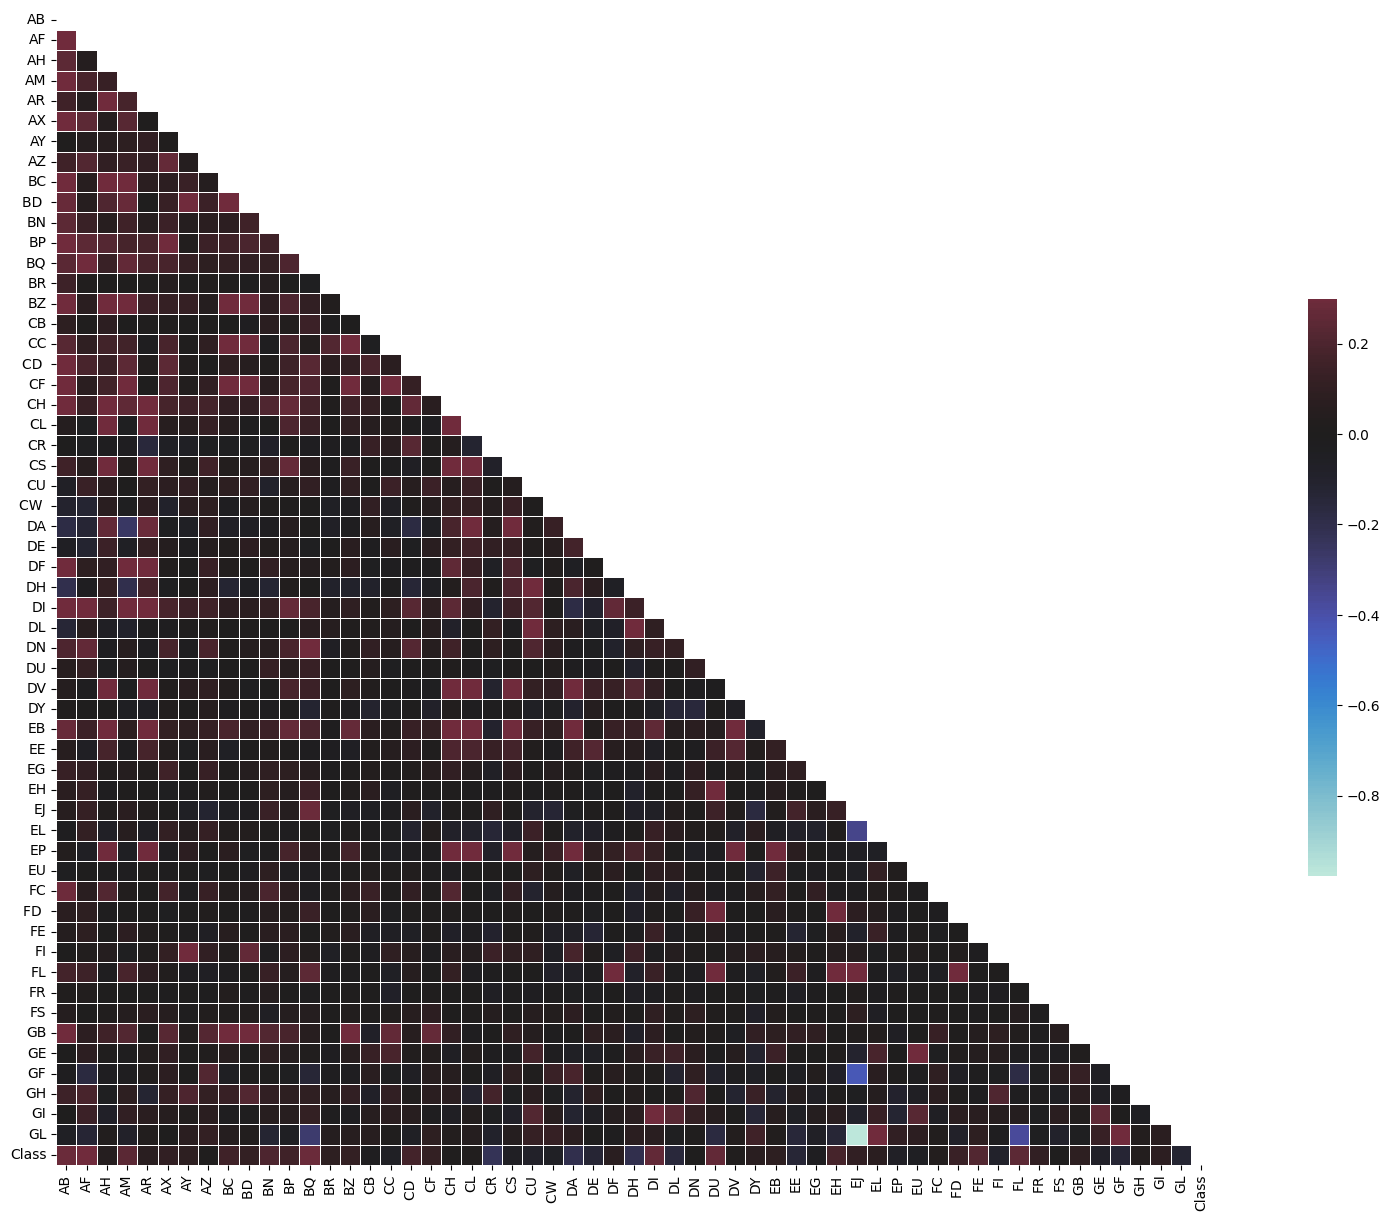

In [10]:
def plot_correlation(df):
    plt.figure(figsize=(35,50))
    # Compute the correlation matrix
    corr = df.corr()    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 15))   
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plot_correlation(train_df)

In [11]:
def OHE(df, column):
    if df[column].isna().any():
        df[column].fillna(0.0001)
    d = {}
    for c in df[column]:
        if c not in d:
            d[c]=len(d)+1
    df[column] = df[column].map(d)

In [12]:
def preprocess(df):
    df = df.fillna(0.0001)
    df.drop(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ'], axis=1, inplace=True)
    
    OHE(df, 'EJ')
    #df.fillna(0, inplace=True)
    df['GL_15'] = df['GL'].rolling(15).mean().fillna(0)
preprocess(train_df)

In [13]:
def get_training_data(df):
    x = df.loc[:, ~df.columns.isin(['Id', 'Class'])]
    y = df['Class']
    return x, y

X, y = get_training_data(train_df)
print(X.shape)
print(y.shape)

(617, 56)
(617,)


In [14]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def lgbm_balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    avg_log_loss = balanced_log_loss/(N_0+N_1)
    # return the average log loss
    return "balanced_log_loss", avg_log_loss, False

In [15]:
COLS = list(train_df)
del COLS[0]
del COLS[-4]

### XGB

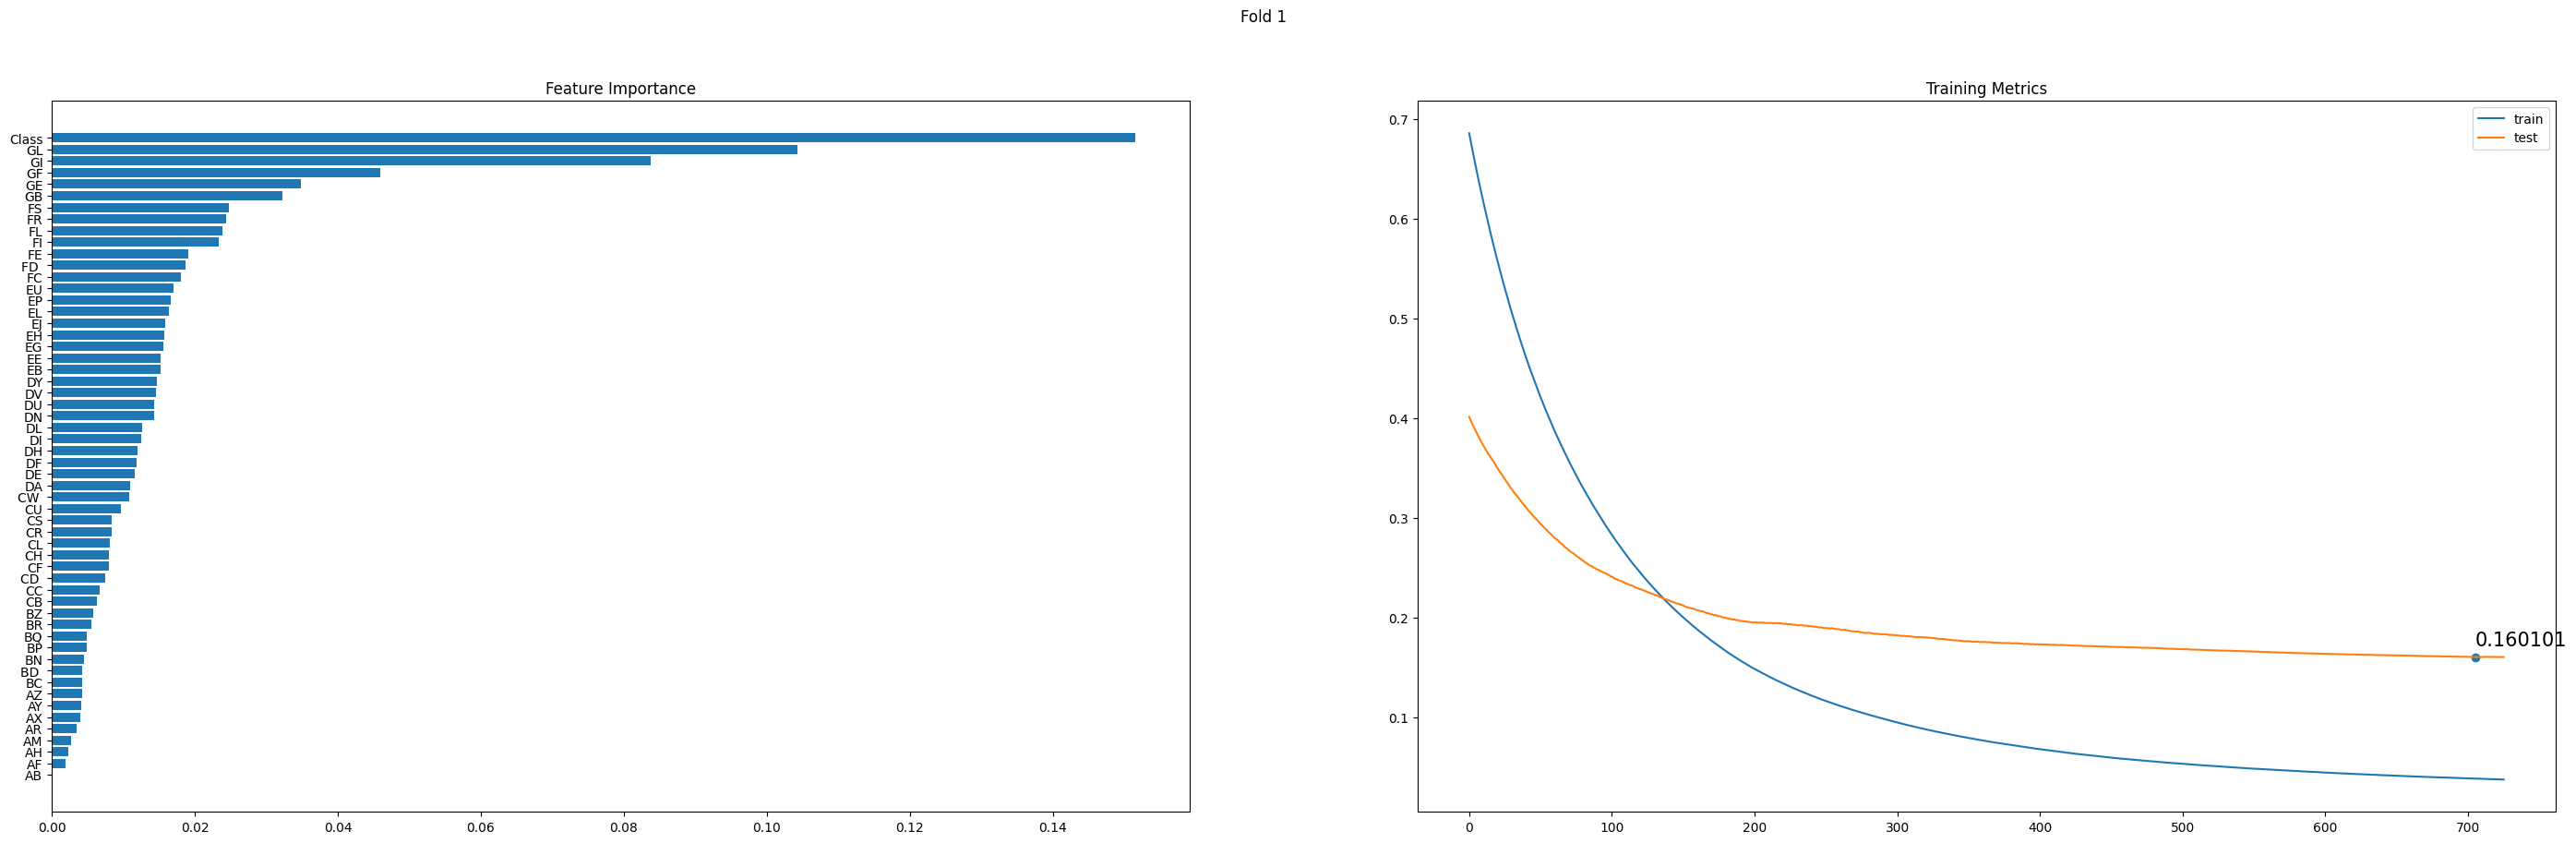

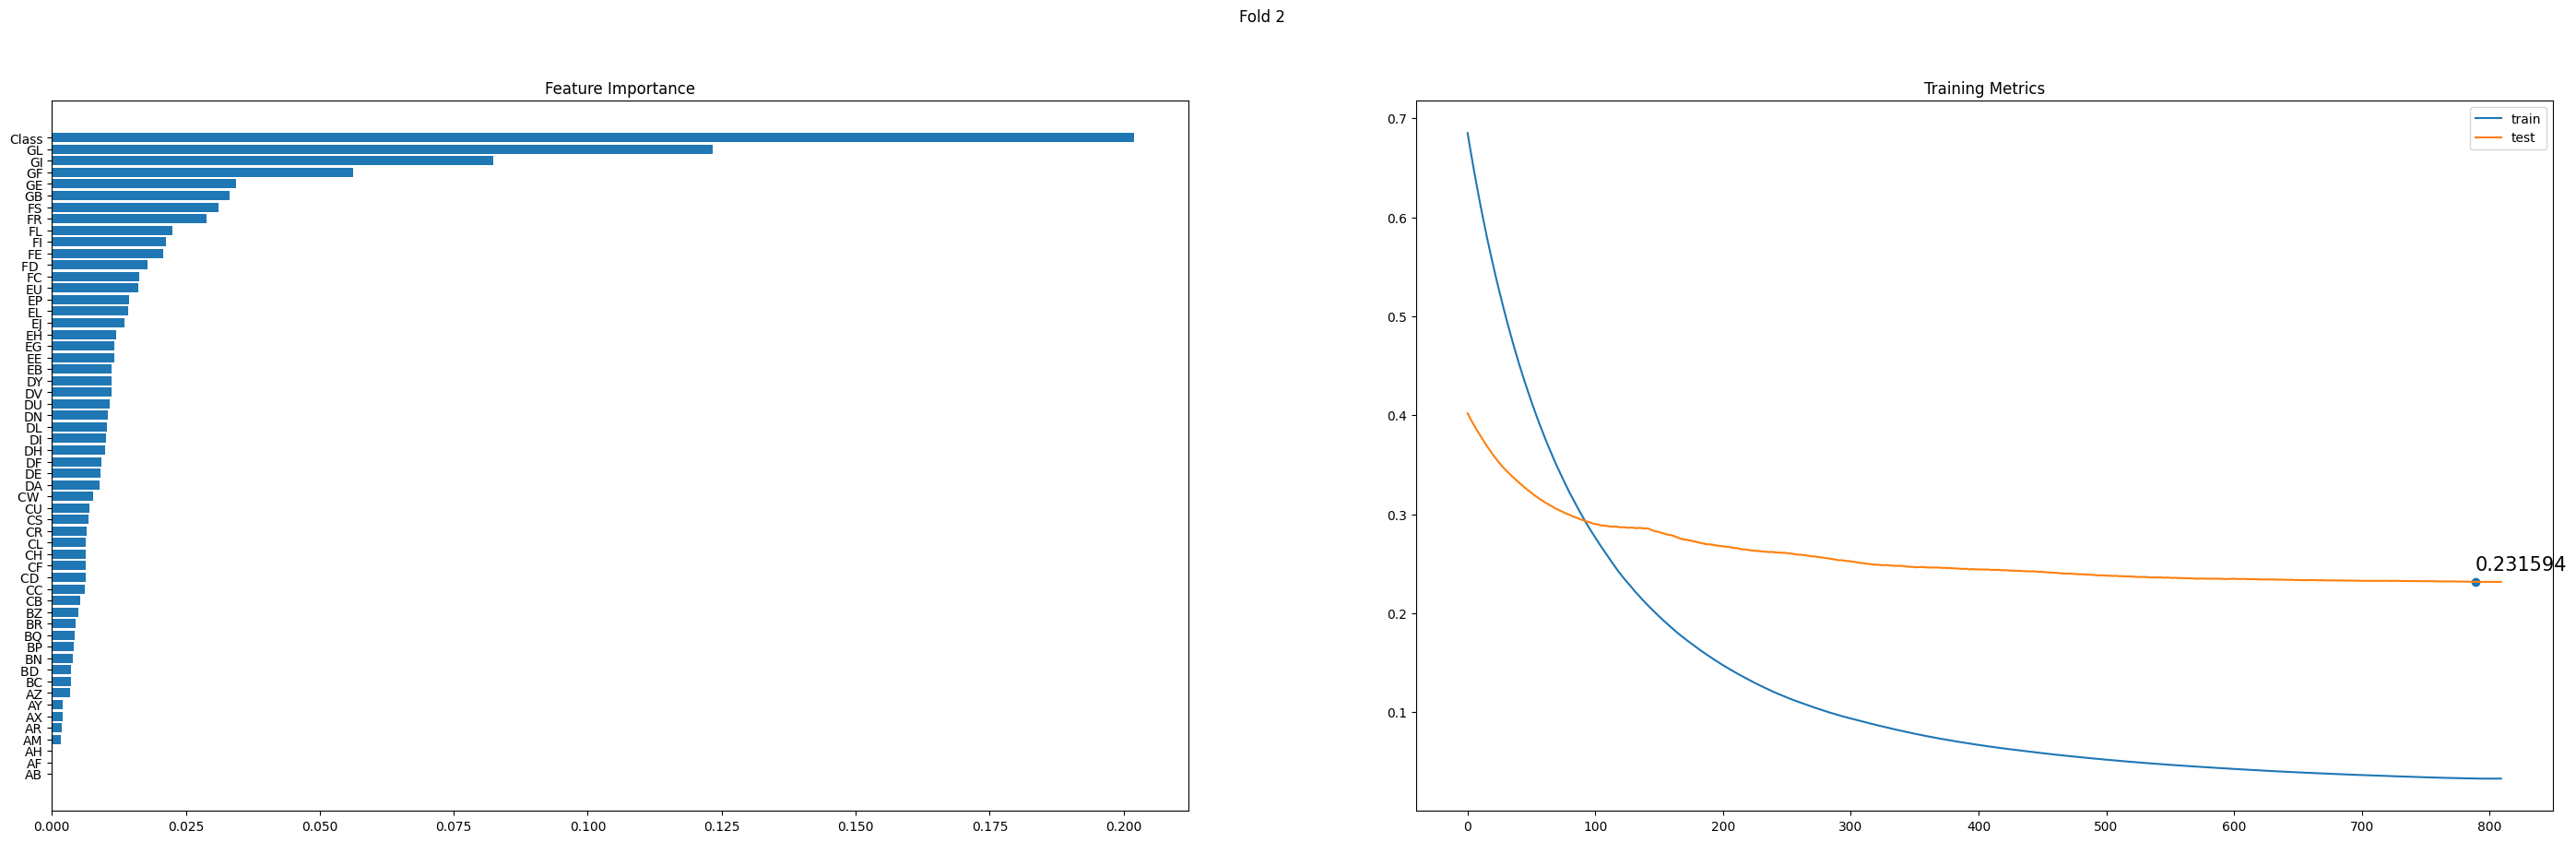

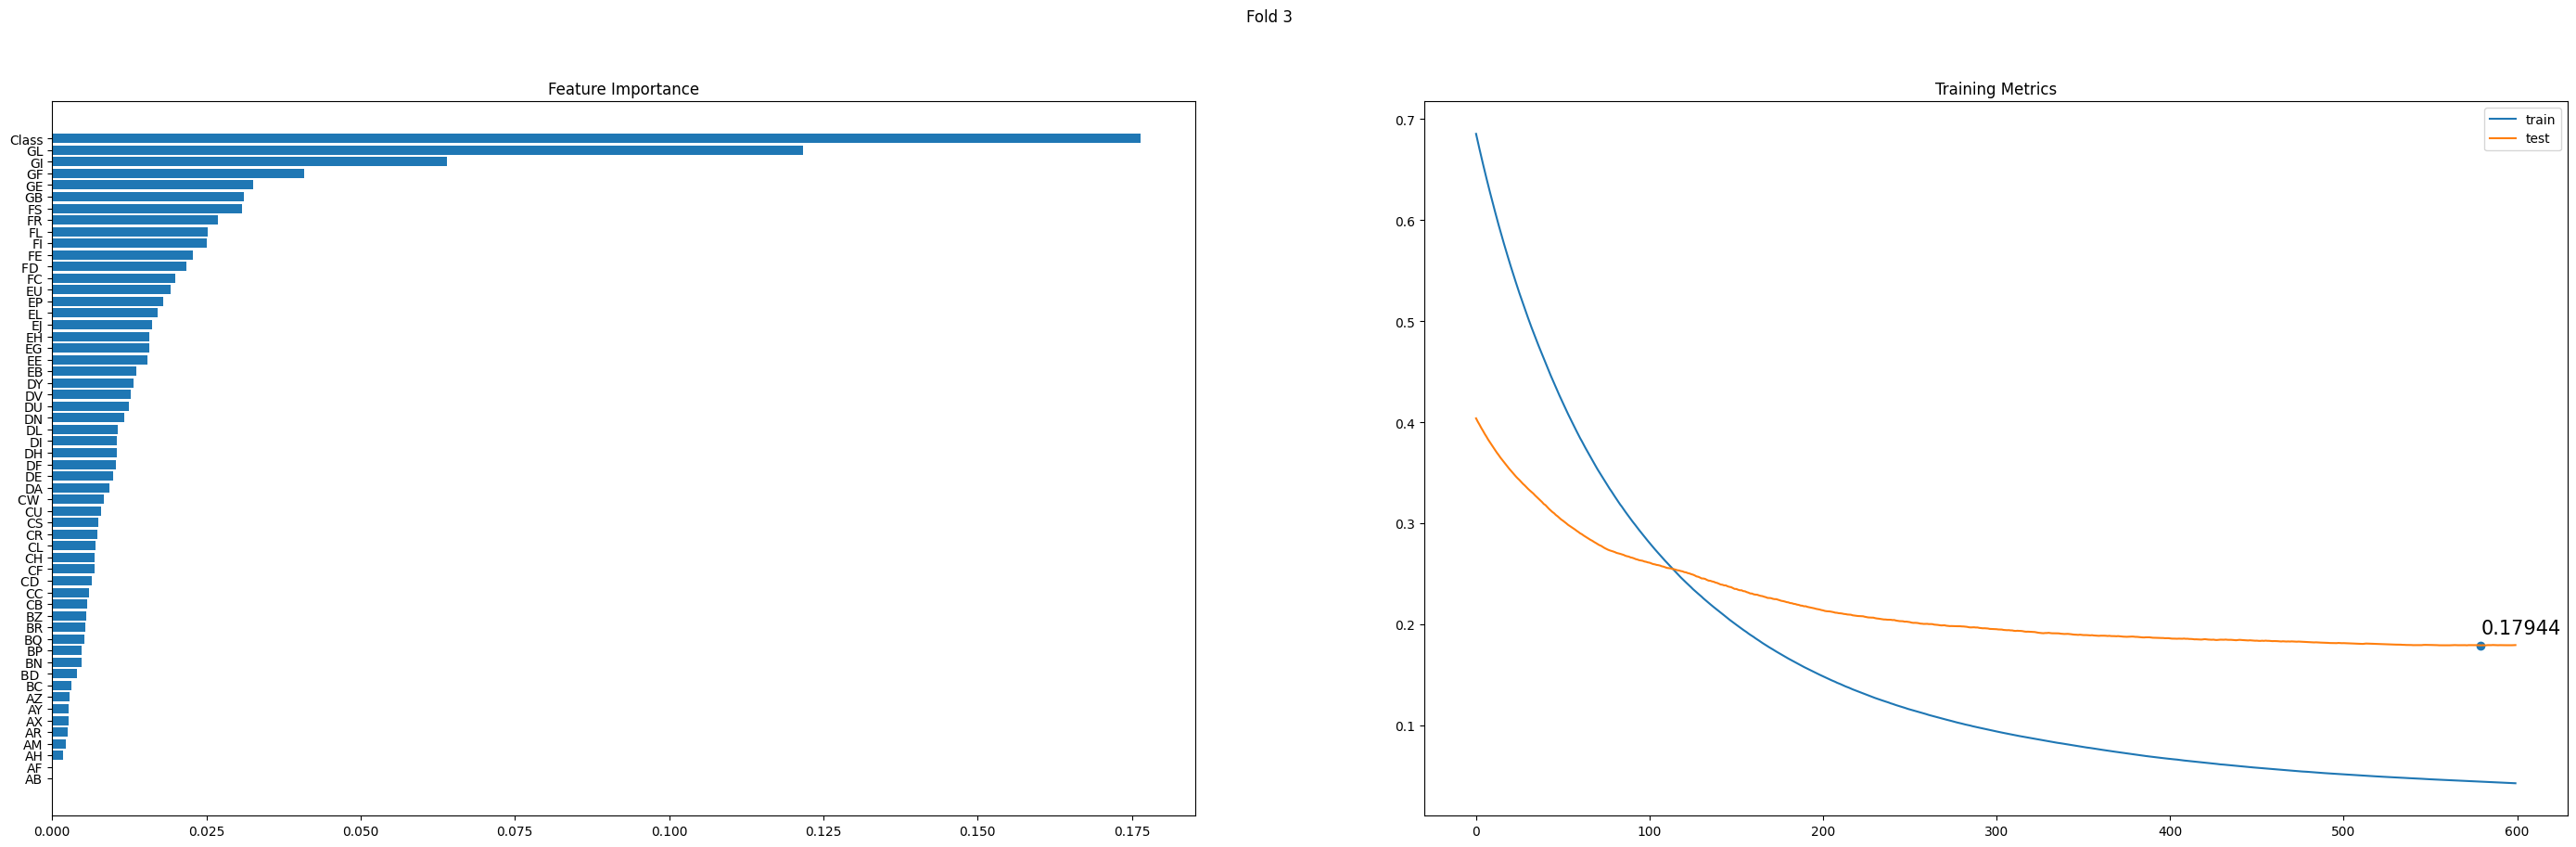

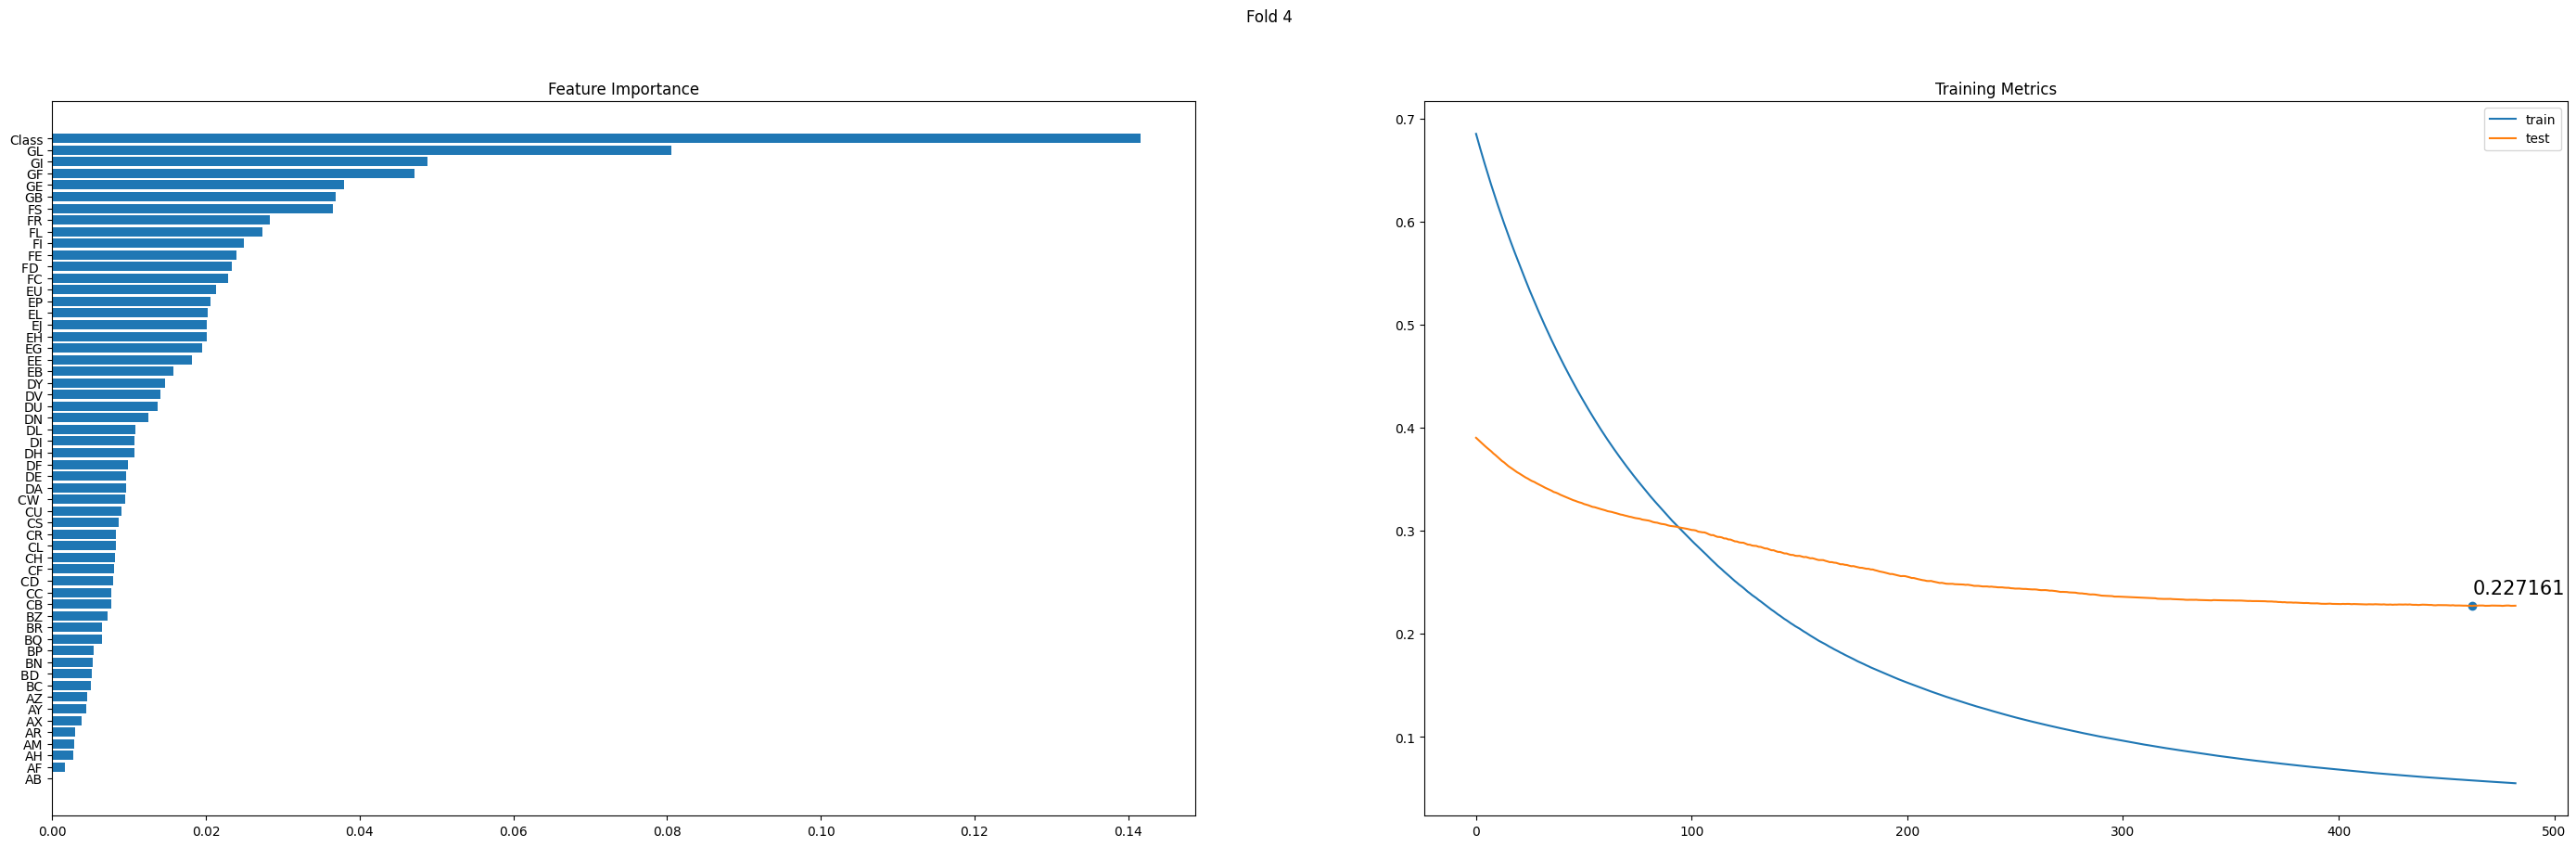

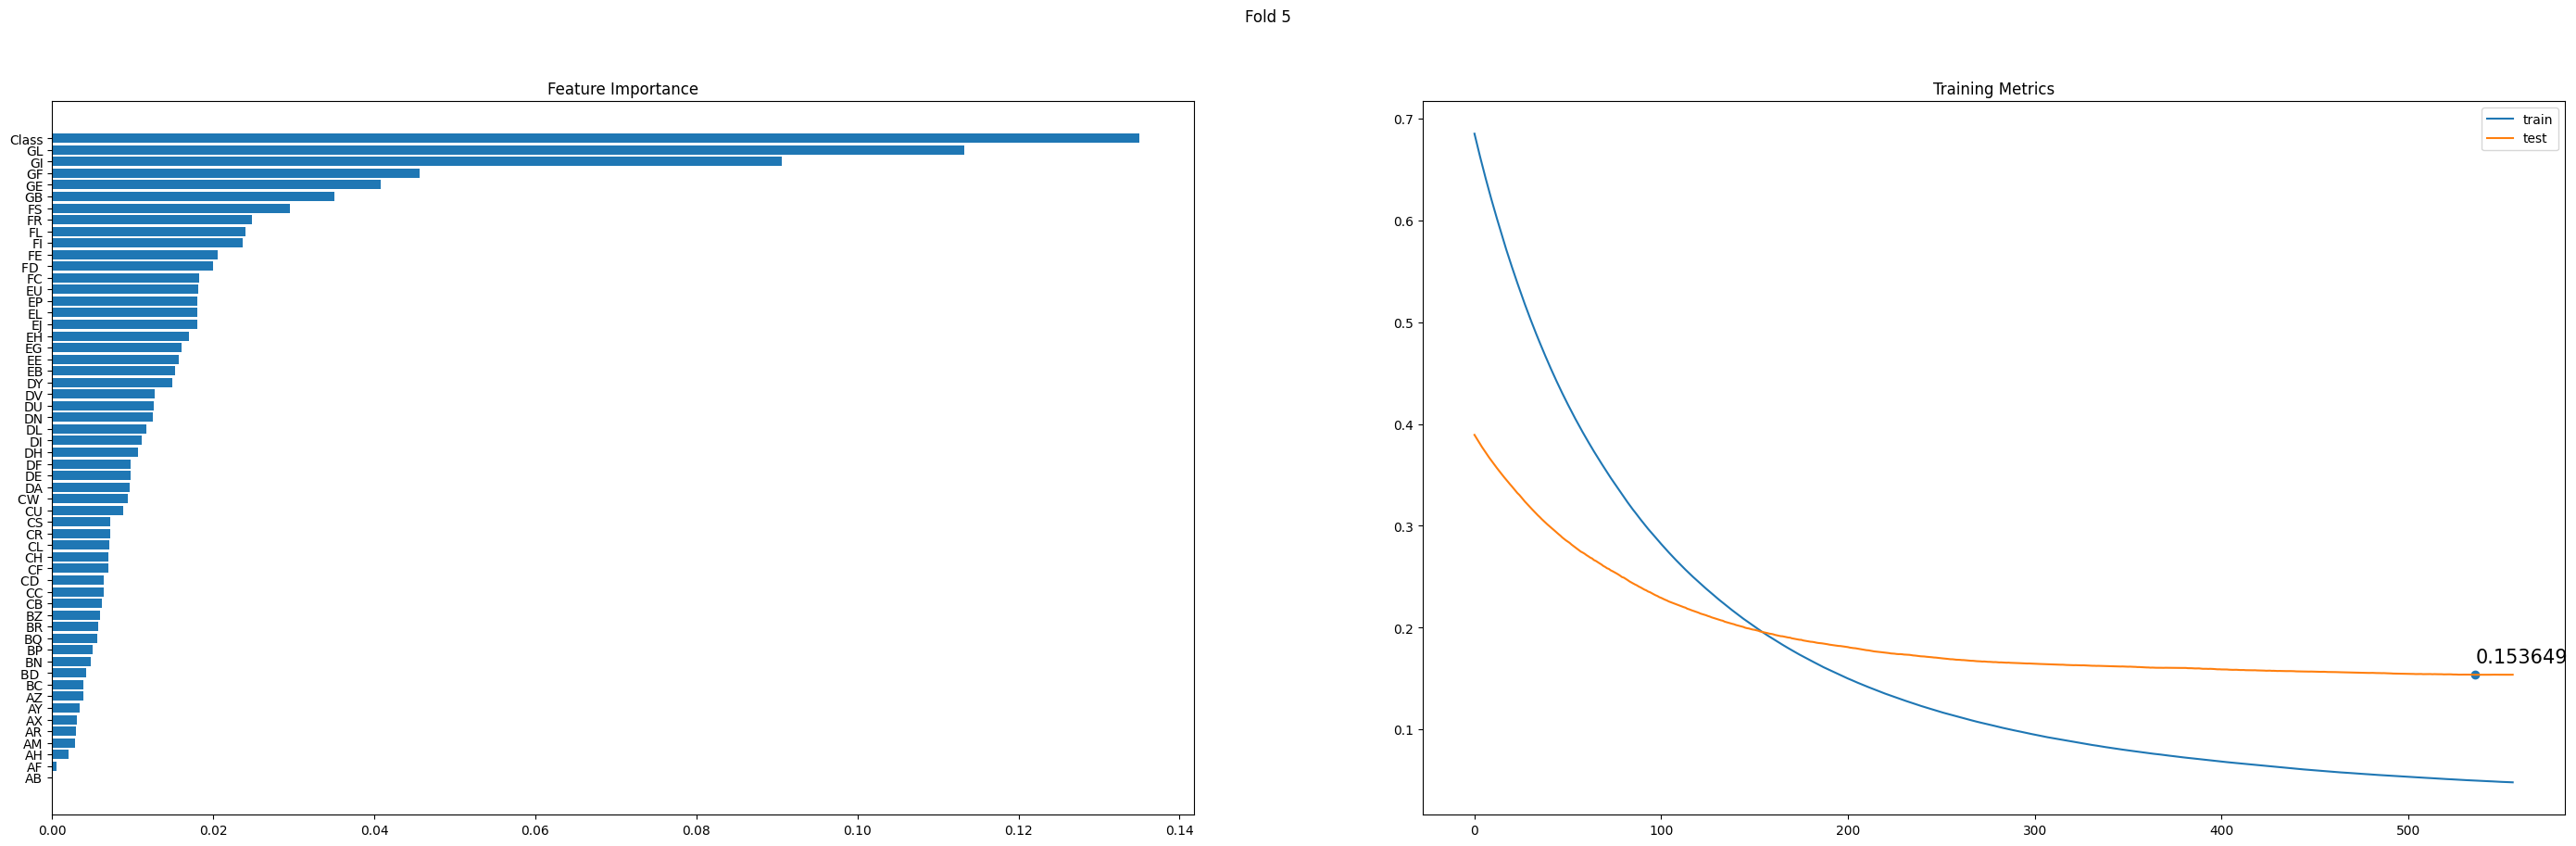

In [16]:
def train_xgb(X, y):
    skf = StratifiedKFold(n_splits=5)
    best_score = 100

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        unique, counts = np.unique(y_train, return_counts=True)
        scale_pos_weight = counts[0]/counts[1]

        model = XGBClassifier(n_estimators=5000,
                              eta=0.01,
                              reg_alpha=2.5,
                              scale_pos_weight=scale_pos_weight,
                              early_stopping_rounds=20, 
                              objective='binary:logistic',
                              eval_metric=balanced_log_loss
        )

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=0
        )

        results = model.evals_result()

        best_iteration = model.get_booster().best_iteration
        min_score = results['validation_1']['balanced_log_loss'][best_iteration]

        if min_score < best_score:
            best_score = min_score
            dump(model, 'xgb.sav')

        fig ,axs = plt.subplots(1, 2, figsize=(35, 10))
        fig.suptitle(f'Fold {i+1}')

        sorted_idx = model.feature_importances_.argsort()
        axs[0].barh( COLS, model.feature_importances_[sorted_idx])
        axs[0].set_title('Feature Importance')
        
        metric_score = min(results['validation_1']['balanced_log_loss'])
        metric_index = results['validation_1']['balanced_log_loss'].index(min(results['validation_1']['balanced_log_loss']))

        axs[1].plot(results['validation_0']['logloss'], label='train')
        axs[1].plot(results['validation_1']['balanced_log_loss'], label='test')
        axs[1].scatter(x=metric_index, y=metric_score)
        axs[1].text(metric_index, metric_score+0.008, str(metric_score), va='bottom', fontsize=15)
        axs[1].set_title(f'Training Metrics')
        axs[1].legend()

        plt.show()
        
    return best_score
xgb_best_score = train_xgb(np.array(X), np.array(y))

### LGBM

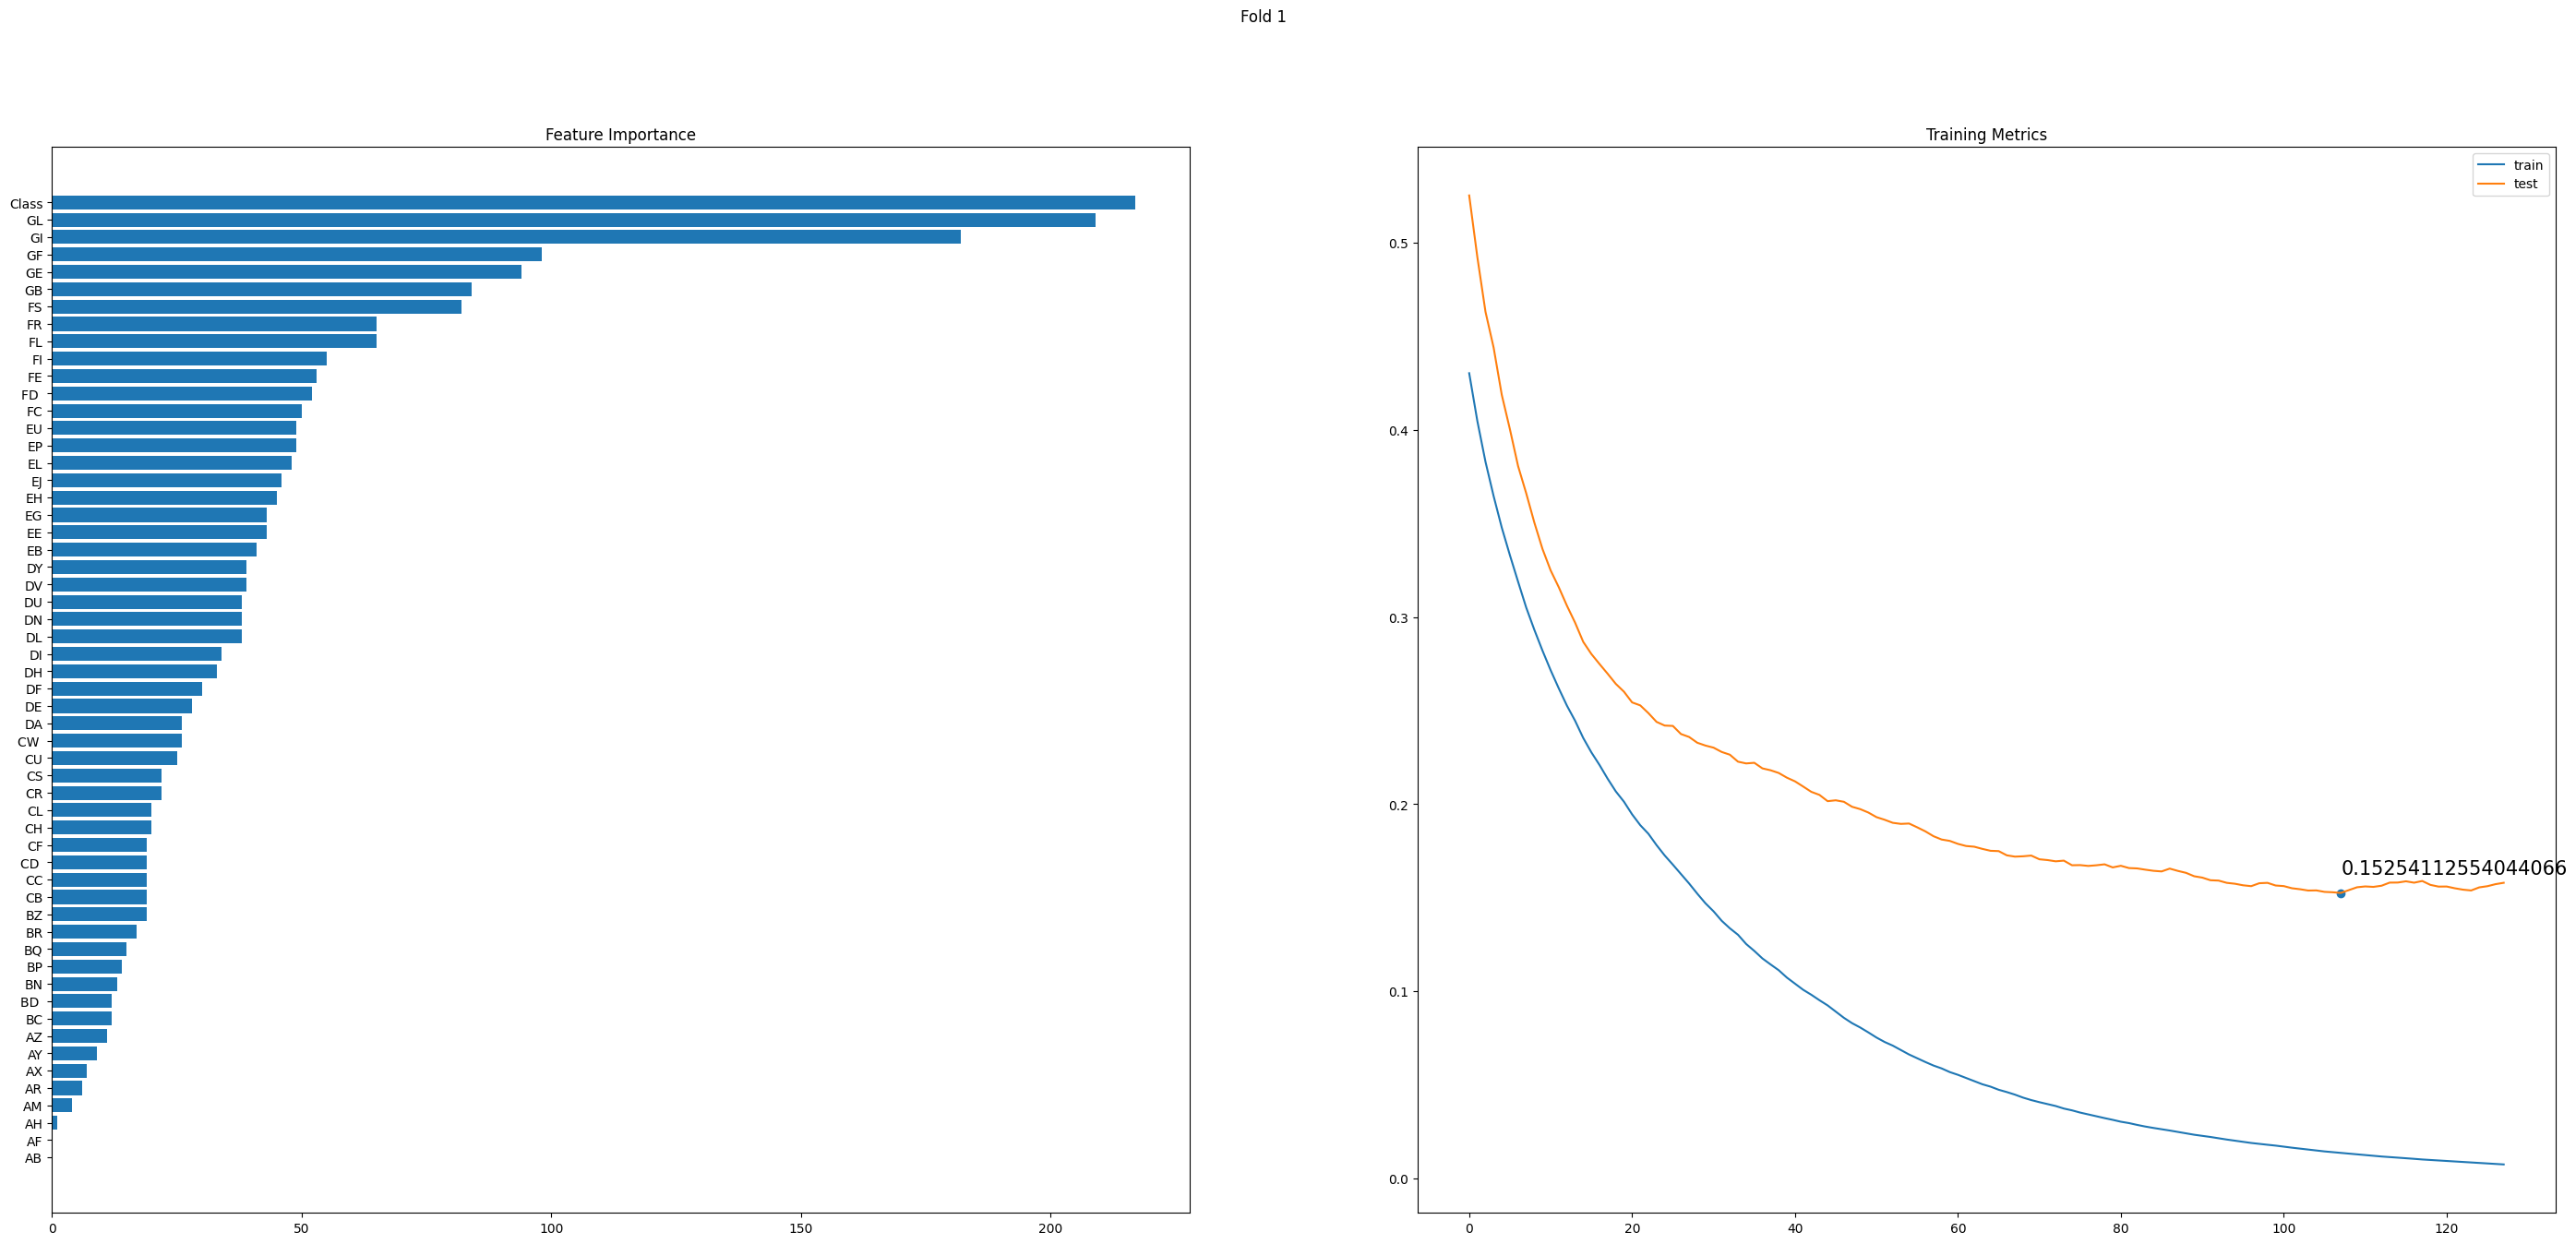

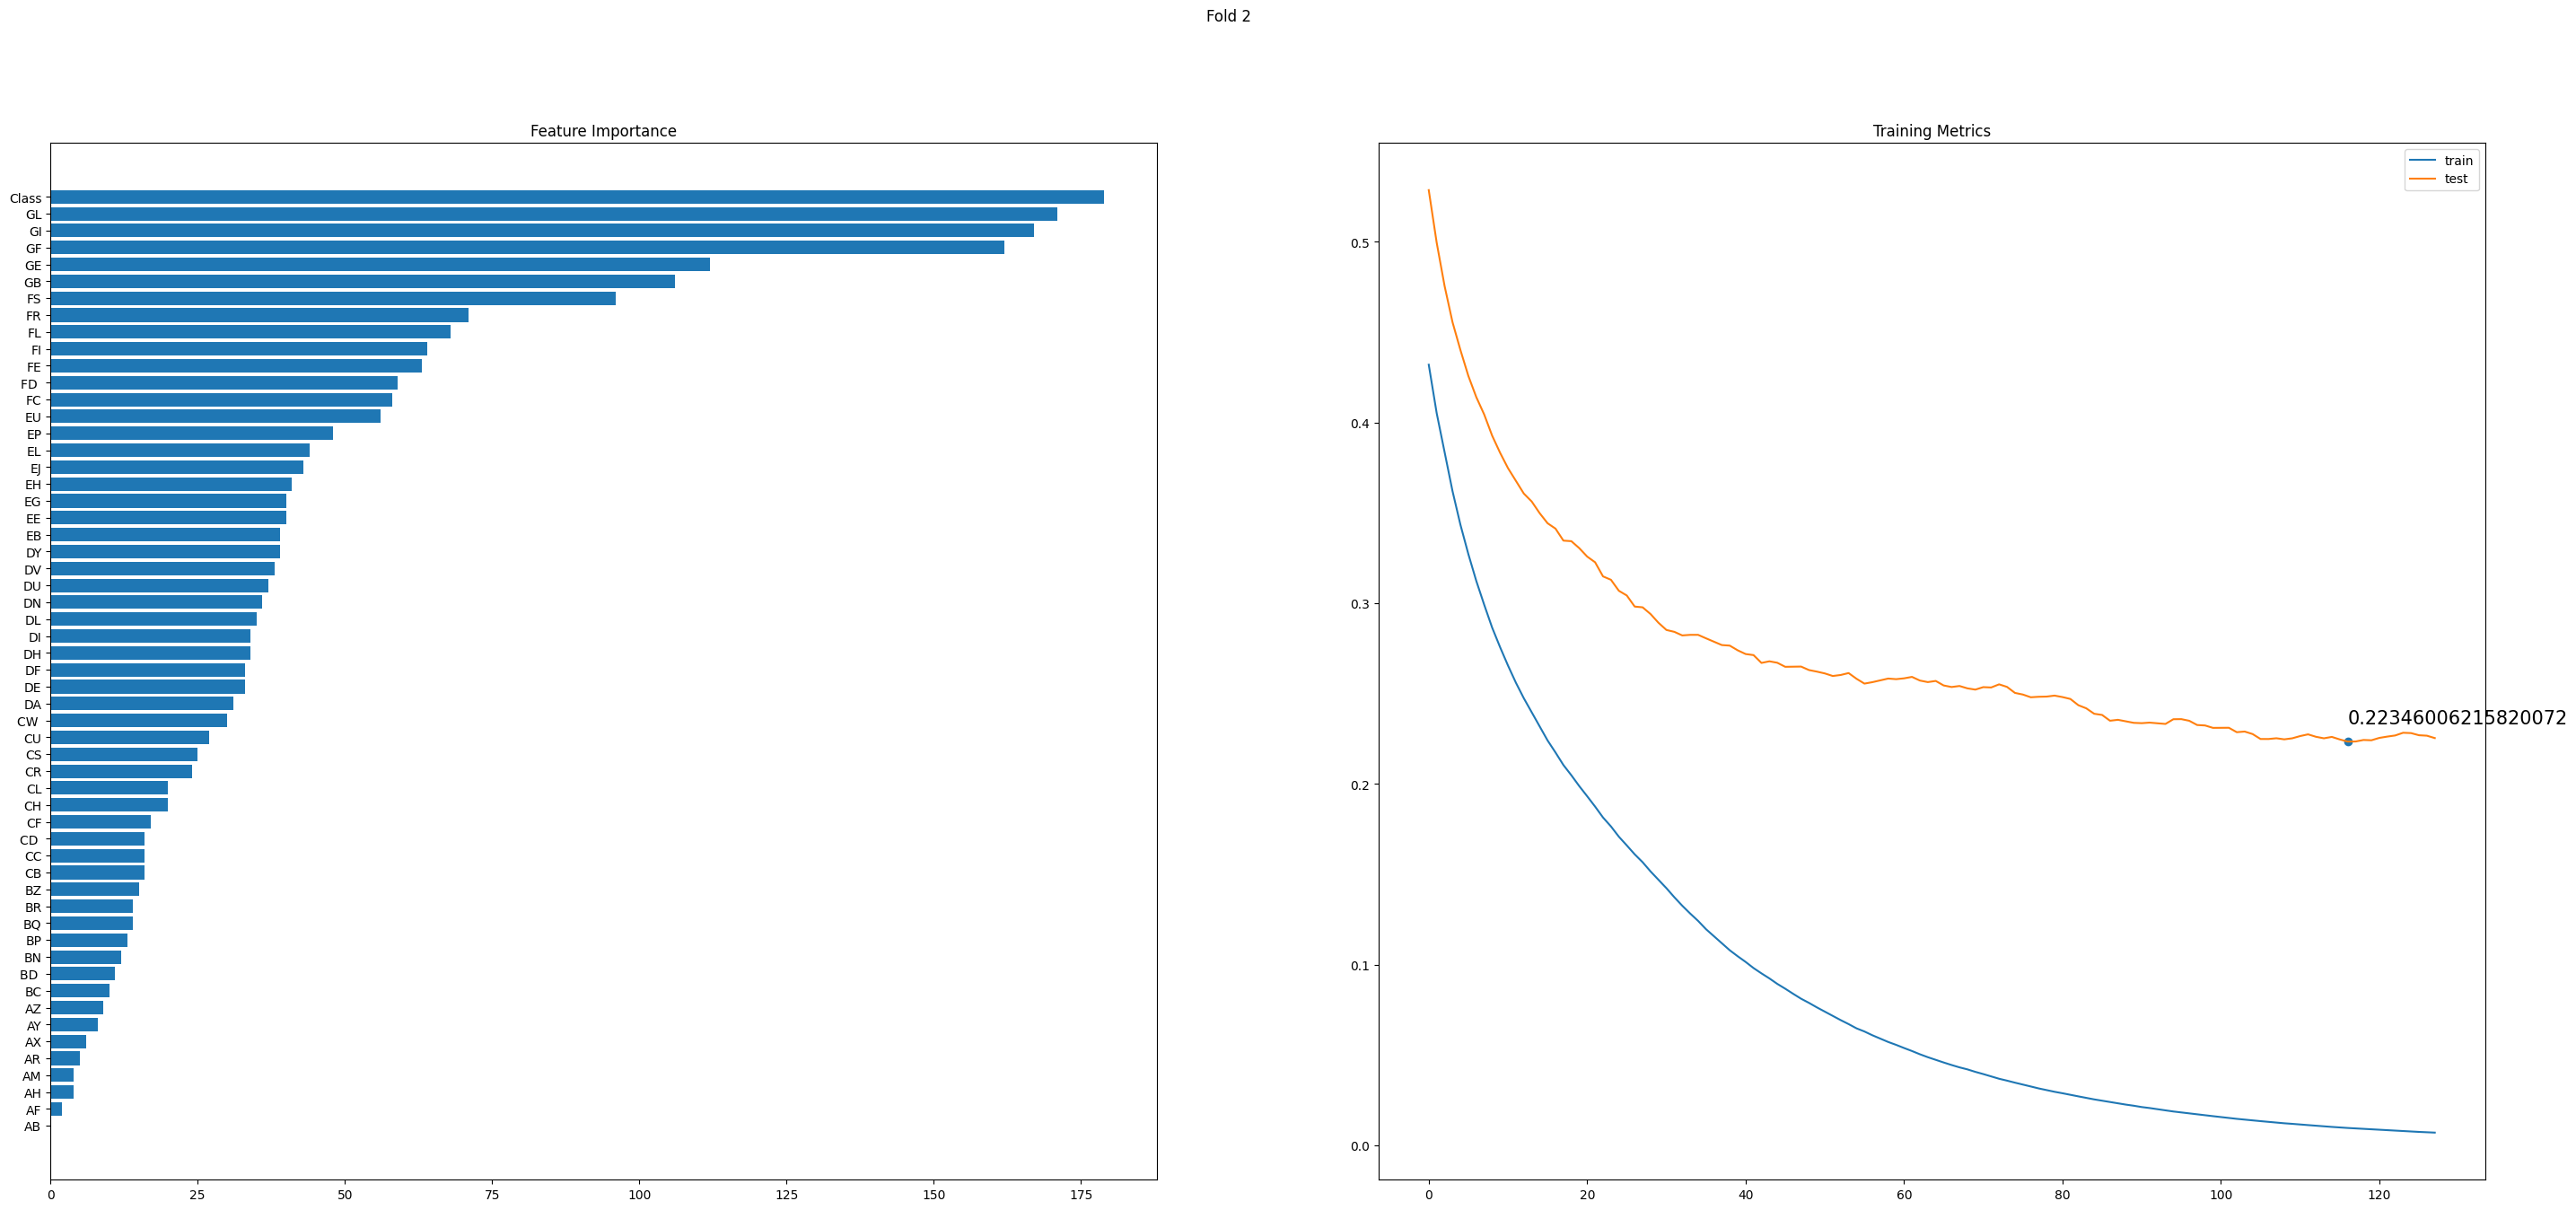

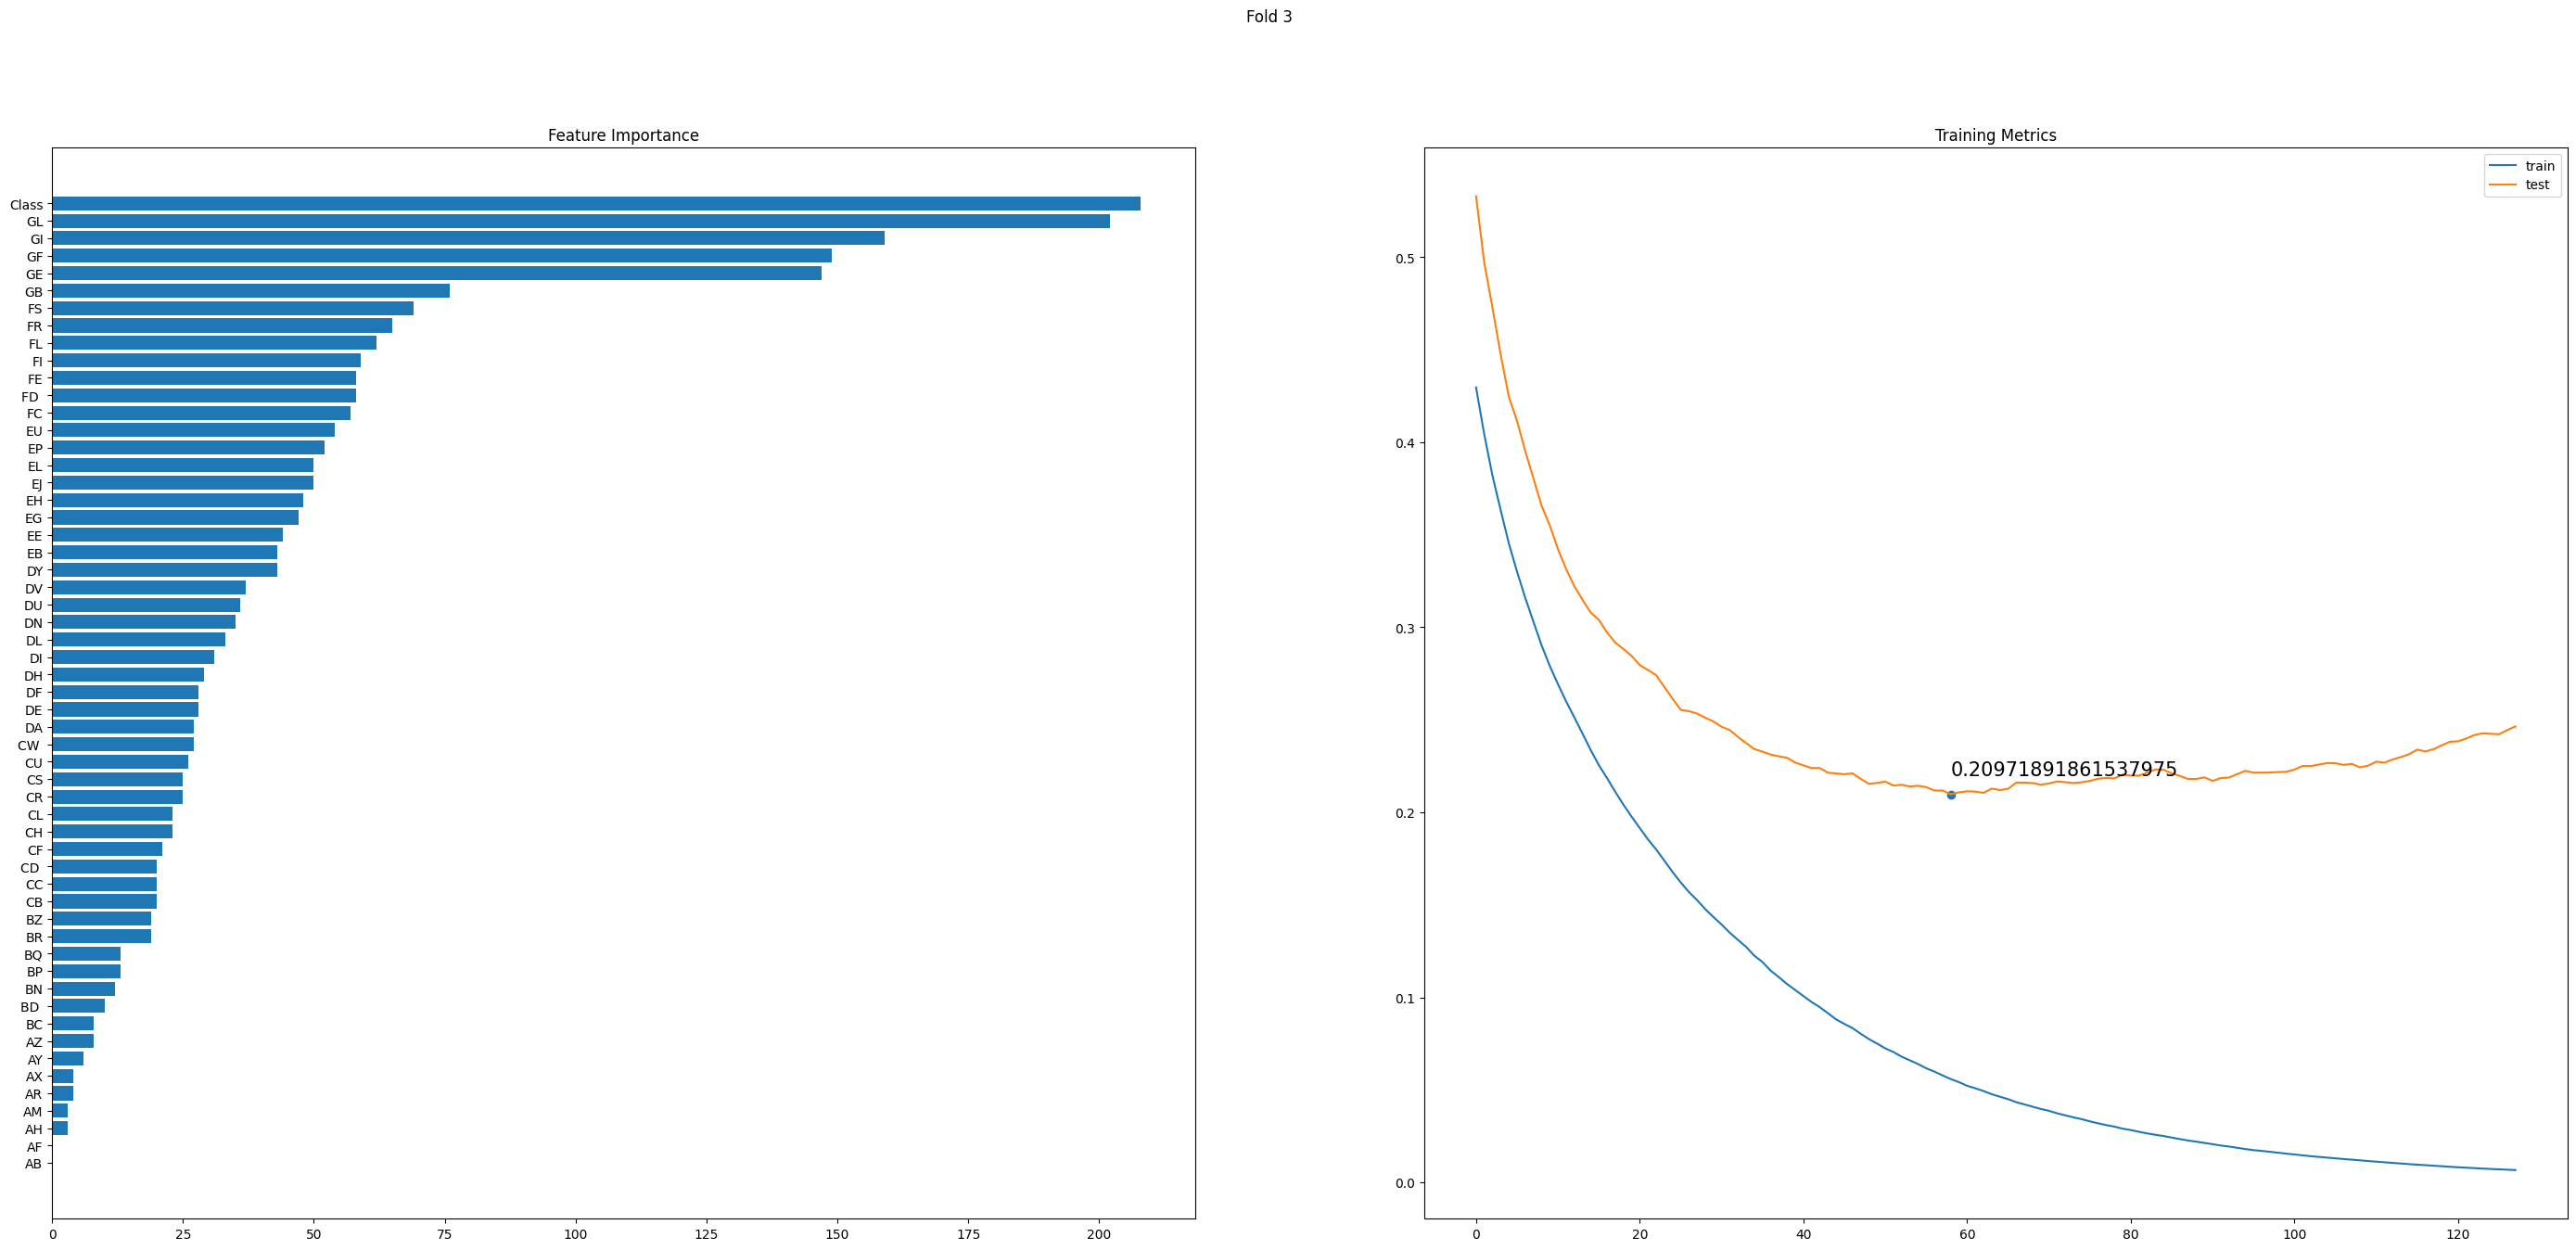

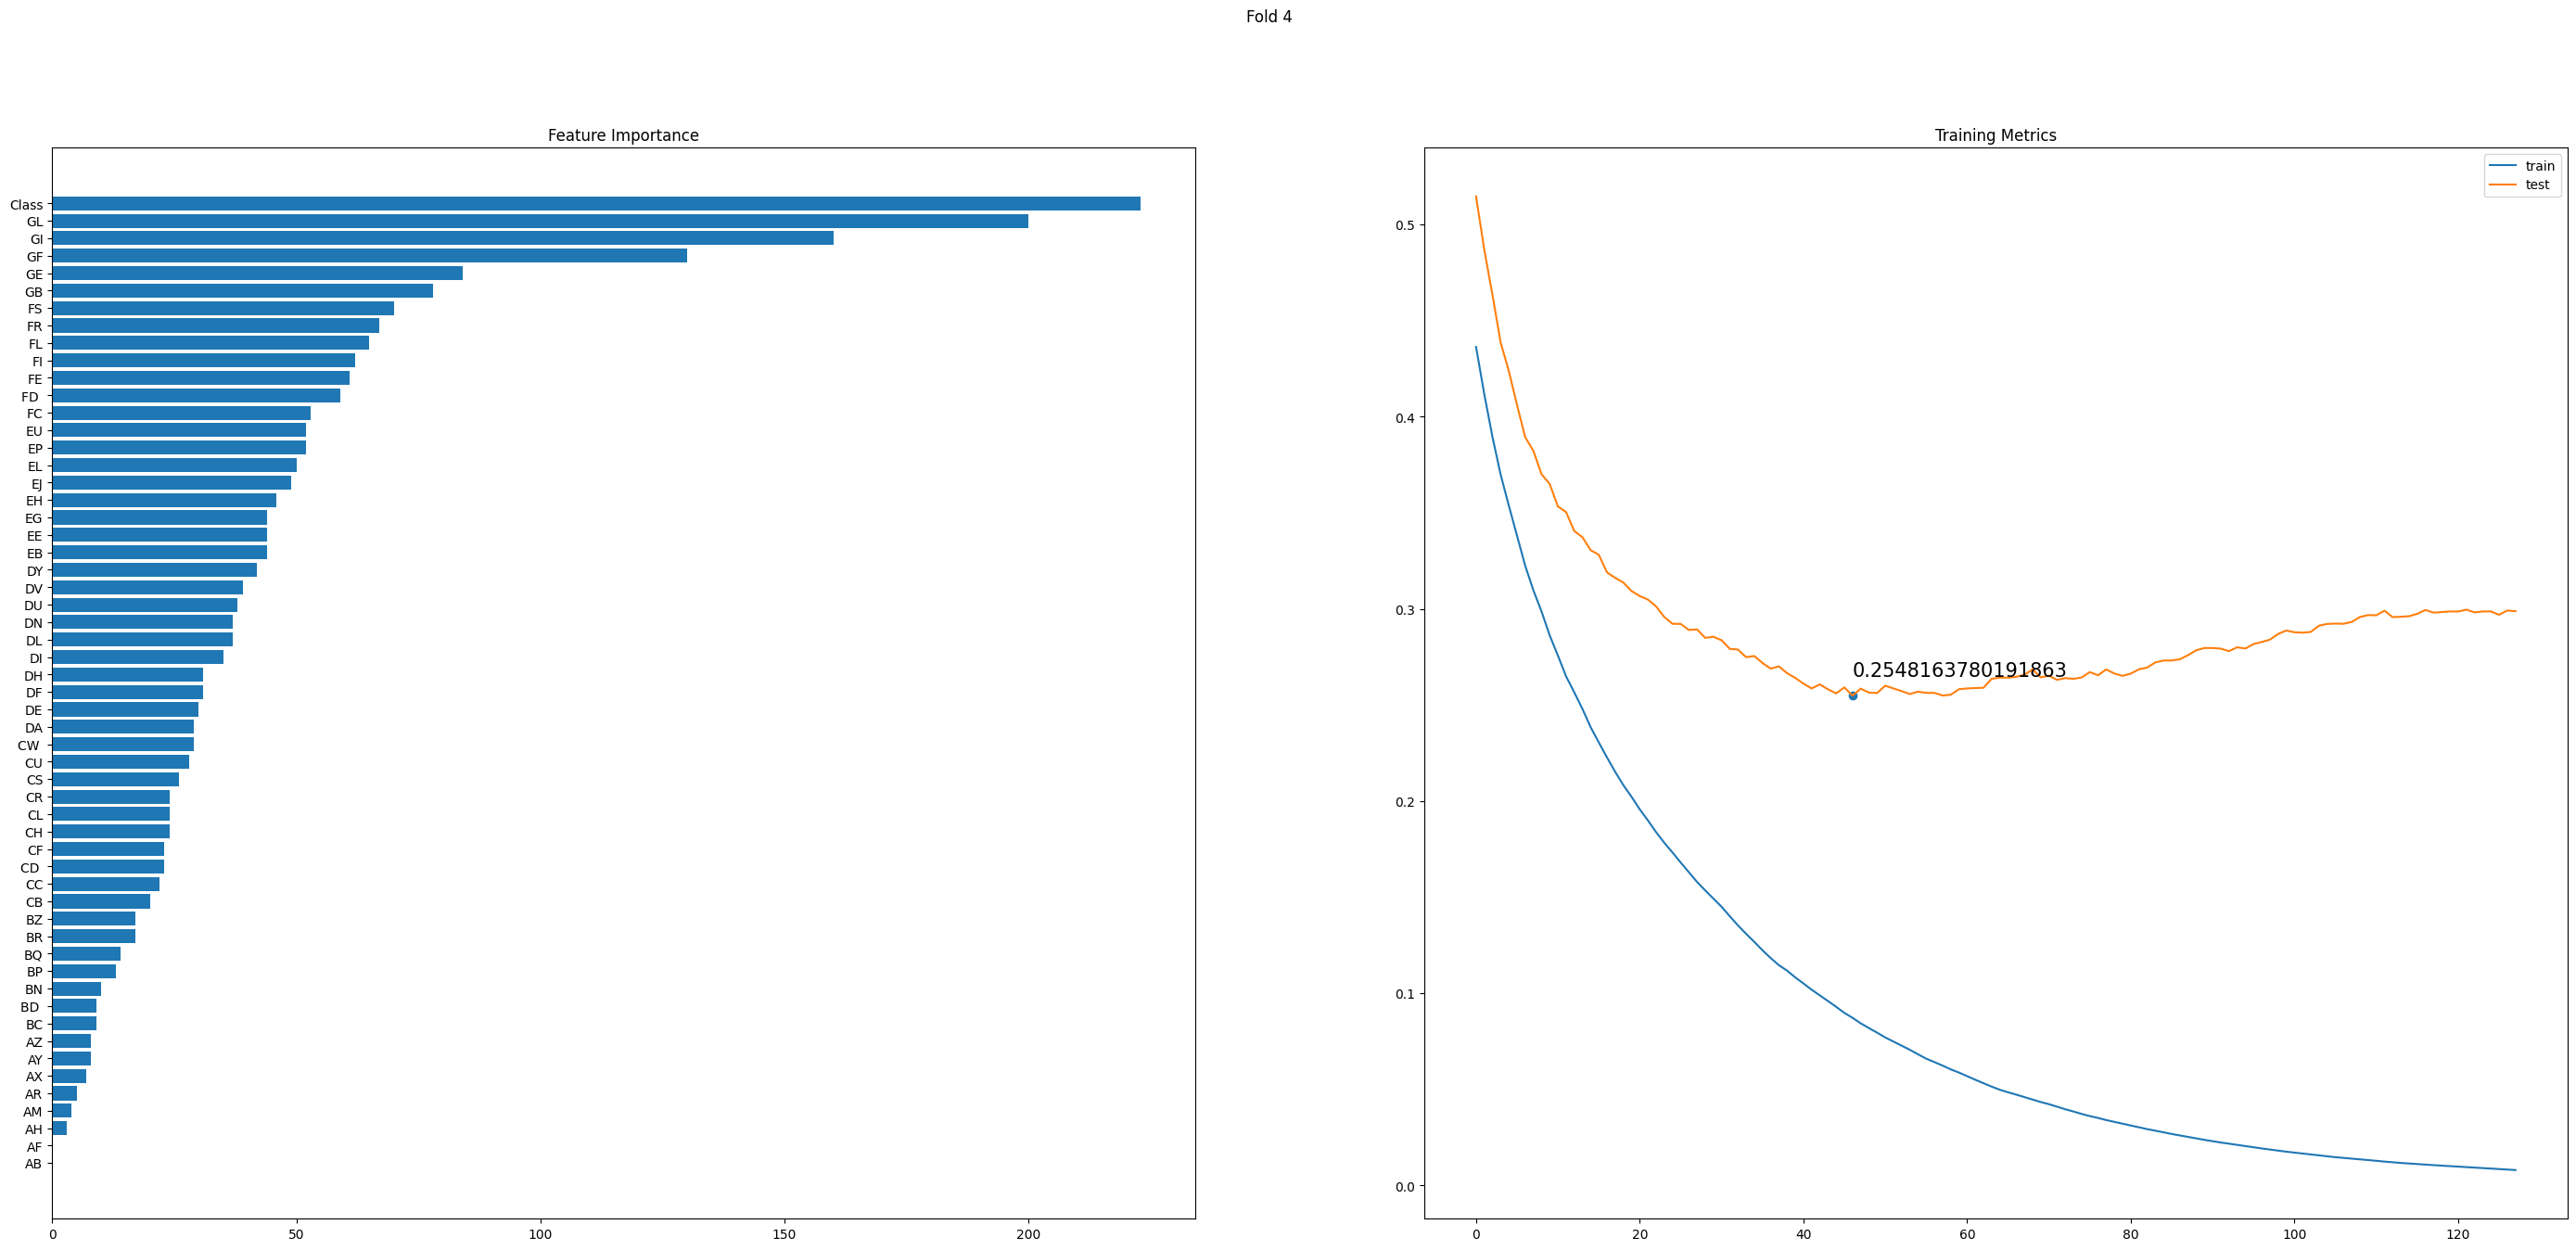

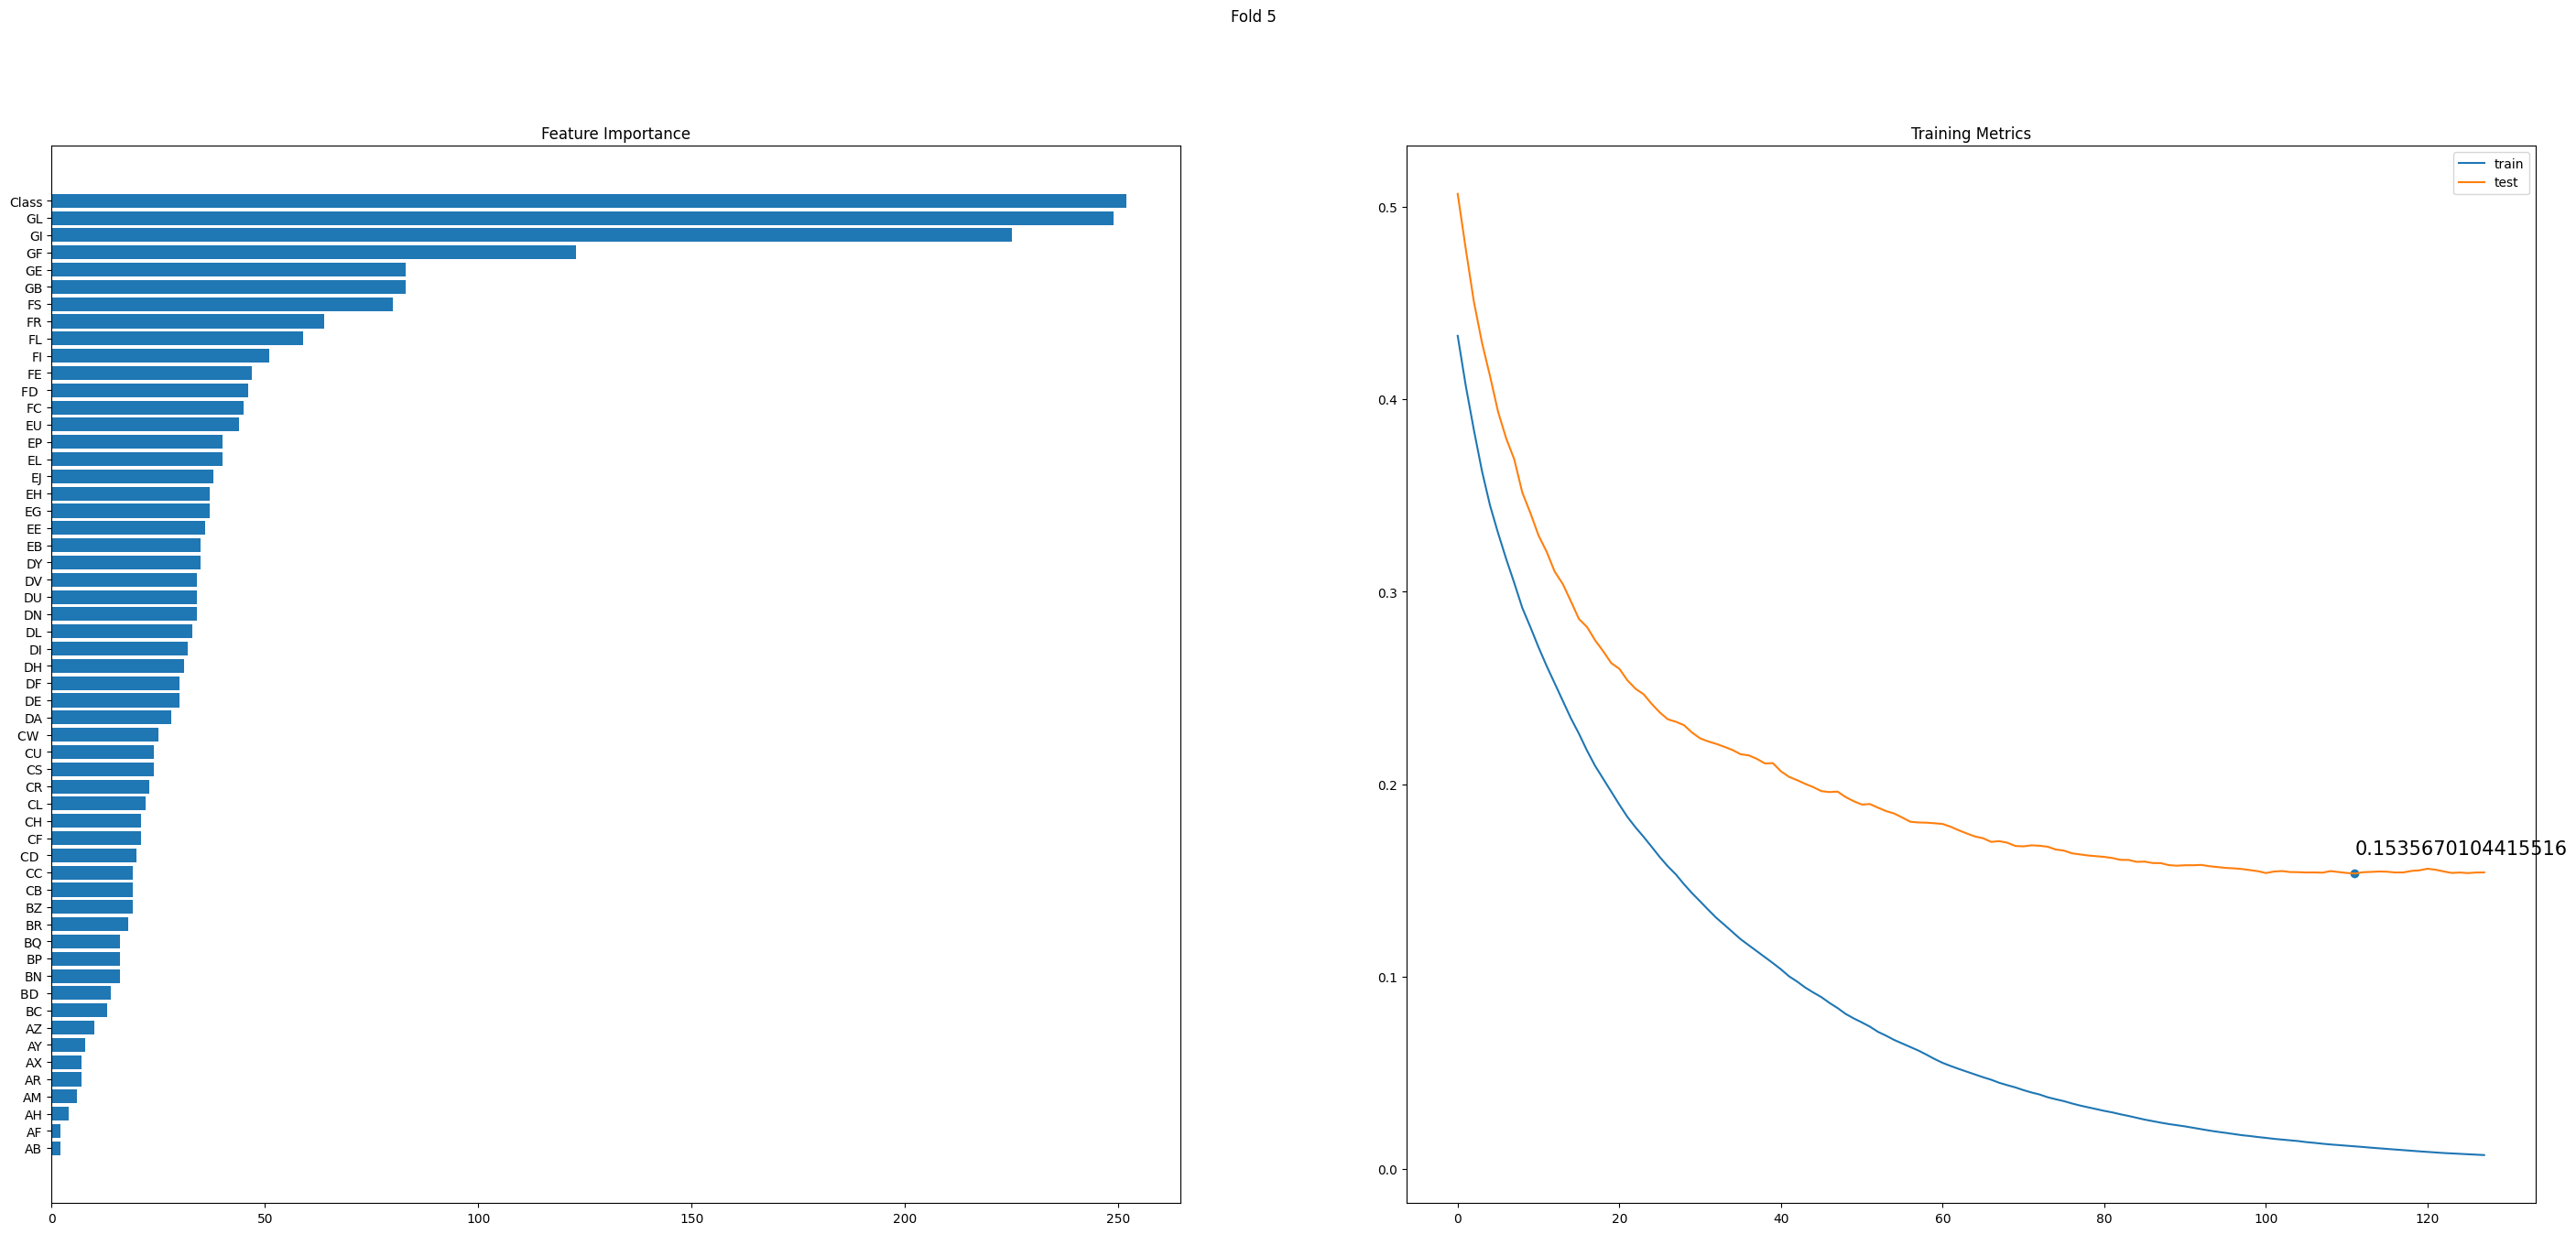

In [17]:
def train_lgbm(X, y):
    skf = StratifiedKFold(n_splits=5)
    best_score = 100
    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=0)]

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        unique, counts = np.unique(y_train, return_counts=True)
        scale_pos_weight = np.sqrt(counts[0]/counts[1])

        model = lgb.LGBMClassifier(n_estimators=5000,
                                   learning_rate=0.05,
                                   scale_pos_weight=scale_pos_weight,                         
                                   objective='binary')
        
        

        model.fit(X_train, y_train,
                  eval_metric=lgbm_balanced_log_loss,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  callbacks=callbacks
                 )


        results = model.evals_result_

        best_iteration = model.best_iteration_
        min_score = results['valid_1']['balanced_log_loss'][best_iteration]

        if min_score < best_score:
            best_score = min_score
            dump(model, 'lgbm.sav')

        fig ,axs = plt.subplots(1, 2, figsize=(35, 15))
        fig.suptitle(f'Fold {i+1}')

        sorted_idx = model.feature_importances_.argsort()
        axs[0].barh( COLS, model.feature_importances_[sorted_idx])
        axs[0].set_title('Feature Importance')
        
        metric_score = min(results['valid_1']['balanced_log_loss'])
        metric_index = results['valid_1']['balanced_log_loss'].index(min(results['valid_1']['balanced_log_loss']))

        axs[1].plot(results['training']['binary_logloss'], label='train')
        axs[1].plot(results['valid_1']['balanced_log_loss'], label='test')
        axs[1].scatter(x=metric_index, y=metric_score)
        axs[1].text(metric_index, metric_score+0.008, str(metric_score), va='bottom', fontsize=15)
        axs[1].set_title(f'Training Metrics')
        axs[1].legend()

        plt.show()
    
    return best_score
lgbm_best_score = train_lgbm(np.array(X), np.array(y))

In [18]:
print(f'XGB Score: {xgb_best_score}')
print(f'LGBM Score: {lgbm_best_score}')

XGB Score: 0.153649
LGBM Score: 0.1540794525132102


In [19]:
def svm_tree(train_data,test_data,exclude,target,max_depth,tp=0):
    #print(rec_dict)
    #nonlocal rec_dict
    if max_depth==1:
        for i in test_data["Id"]:
            rec_dict[i]=tp
    else:
        X,y = train_data[[c for c in train_data.columns if (c not in exclude and c!=target)]],train_data[target]
        test_X = test_data[[c for c in train_data.columns if (c not in exclude and c!=target)]]
        svm = SVC()
        svm.fit(X,y)
        y_pred= svm.predict(X)
        y_pred1 = svm.predict(test_X)
        ones,zeros = train_data[y_pred==1],train_data[y_pred==0]
        test_ones,test_zeros = test_data[y_pred1==1],test_data[y_pred1==0]
        t1,t2 = False,False
        for i in ones.index:
            if ones[target][i]==0:
                t1 = True
                break
        for i in zeros.index:
            if zeros[target][i]==0:
                t2 = True
                break
        if t1 and len(test_ones)>1:
            svm_tree(ones,test_ones,exclude,target,max_depth-1,1)
        else:
            for i in test_ones.index:
                rec_dict[test_ones_index["Id"][i]]=1
        if t2 and len(test_zeros)>1:
            svm_tree(zeros,test_zeros,exclude,target,max_depth-1,0)
        else:
            for i in test_ones.index:
                rec_dict[test_ones_index["Id"][i]]=1

In [20]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [21]:
test_df[['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ']]

,AB,AF,AH,AM,AR,AX,AY,AZ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Submission

In [22]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
#test_df = test_df[[c for c in test_df.columns if c!="Class"]]
test_df = test_df.fillna(0.0001)
test_df["EJ"] = test_df["EJ"].map({"A":0.0001,"B":0.9999})
xgb = load("xgb.sav")
lgbm = load("lgbm.sav")


In [23]:
train_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
train_df = train_df.fillna(0.0001)
train_df["EJ"] = train_df["EJ"].map({"A":0.0001,"B":0.9999})

In [24]:
test_df["EJ"]

0    0.0001
1    0.0001
2    0.0001
3    0.0001
4    0.0001
Name: EJ, dtype: float64

In [25]:
rec_dict = {}
svm_tree(train_df,test_df,{"Id"},"Class",9,tp=0)

In [26]:
rec_dict

{'00eed32682bb': 0,
 '010ebe33f668': 0,
 '02fa521e1838': 0,
 '040e15f562a2': 0,
 '046e85c7cc7f': 0}

In [27]:

for i, row in test_df.iterrows():
    idx = row['Id']
    row.drop('Id', inplace=True)
    batch = row.to_numpy()
    batch = batch[np.newaxis, :]
    #print(batch)
    xgb_pred = xgb.predict_proba(batch).squeeze()
    lgbm_pred = lgbm.predict_proba(batch).squeeze()
    #print(svm_pred)
   
   
    
    test_df.at[i, 'class_0'] = (xgb_pred[0] * 0.7) + (lgbm_pred[0] * 0.2) + 0.1*(1-rec_dict[idx])
    test_df.at[i, 'class_1'] = (xgb_pred[1] * 0.7) + (lgbm_pred[1] * 0.2) + 0.1*(rec_dict[idx])

test_df[['Id', 'class_0', 'class_1']].to_csv('submission.csv', index = False)
print(test_df)

             Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FR   FS  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    GB   GE   GF   GH   GI   GL   class_0   class_1  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.924358  0.075642  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.924358  0.075642  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.924358  0.075642  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.924358  0.075642  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.924358  0.075642  

[5 rows x 59 columns]
